<AxesSubplot:xlabel='year'>

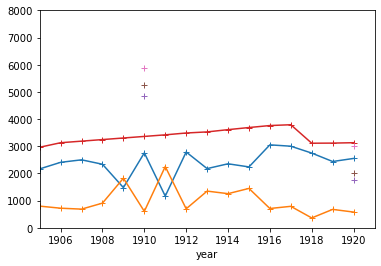

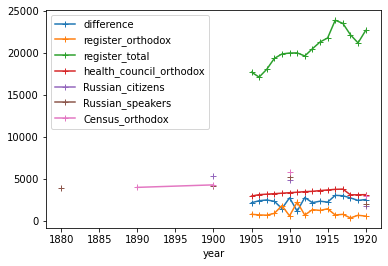

In [1]:
import warnings
from pathlib import Path

import pandas as pd
import numpy as np

data_dir = Path('../data')
warnings.simplefilter(action='ignore', category=FutureWarning)

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

districts_in_city = [
    'Valli',
    'Salakkalahti',
    'Repola',
    'Anina',
    'Papula',
    'P_Annan_kruunu',
    'Hiekka',
    'Pantsarlahti',
    'Viipurin_esikaupunki',
    'Paulovski',
    'Havi',
    'Saunalahti',
    'Pietarin_esikaupunki',
]

poll_tax = pd.read_csv(data_dir / 'poll_tax_register.csv', index_col=0)
poll_tax['total'] = poll_tax.total_women + poll_tax.total_men
health_council = pd.read_csv(data_dir / 'health_council.csv', index_col=0).pop_orthodox
health_council = health_council.reindex(range(1905, 1921), fill_value=np.nan).interpolate(method='slinear')
foreigners = pd.read_csv(data_dir / 'foreigners.csv', index_col=0).russia
language = pd.read_csv(data_dir / 'language.csv', index_col=0).russian
religion = pd.read_csv(data_dir / 'religion.csv', index_col=0).orthodox
difference = health_council - poll_tax.orthodox
data = pd.DataFrame([difference, poll_tax.orthodox, poll_tax.total, health_council, foreigners, language, religion]).T
data.columns = ['difference', 'register_orthodox', 'register_total', 'health_council_orthodox', 'Russian_citizens', 'Russian_speakers', 'Census_orthodox']
# data.interpolate(method='linear', inplace=True)
data.plot(marker='+', legend=False, xlim=(1905, 1921), ylim=(0, 8000))
data.plot(marker='+')

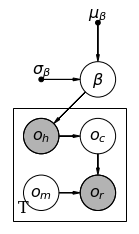

In [2]:
import daft
from matplotlib import rc

rc("font", family="serif", size=16)
scale = 1.25
pgm = daft.PGM()

pgm.add_node('sigma', r'$\sigma_{\beta}$', 1, 3, fixed=True)
pgm.add_node('mu', r'$\mu_{\beta}$', 2, 4, fixed=True)
pgm.add_node('health_orthodox', r'$o_h$', 1, 2, fixed=False, scale=scale, observed=True)
pgm.add_node('city_orthodox', r'$o_c$', 2, 2, fixed=False, scale=scale, observed=False)
pgm.add_node('register_orthodox', r'$o_r$', 2, 1, fixed=False, scale=scale, observed=True)
pgm.add_node('missing_orthodox', r'$o_m$', 1, 1, fixed=False, scale=scale, observed=False)
pgm.add_node('beta_orthodox_city', r'$\beta$', 2, 3, fixed=False, scale=scale, observed=False)

pgm.add_edge('sigma', 'beta_orthodox_city', directed=True)
pgm.add_edge('mu', 'beta_orthodox_city', directed=True)
pgm.add_edge('beta_orthodox_city', 'health_orthodox', directed=True)
pgm.add_edge('city_orthodox', 'register_orthodox', directed=True)
pgm.add_edge('health_orthodox', 'city_orthodox', directed=True)
pgm.add_edge('missing_orthodox', 'register_orthodox', directed=True)

pgm.add_plate([0.5, 0.5, 2, 2], 'T')

pgm.render()

Model:

$ o_r = o_c - o_m $

In [6]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

with pm.Model() as model:
    mu = [2000, 0.5]
    sigma = [10, 0.5]
    t = pm.Data('t', pd.Series(poll_tax.index))
    n = len(t)
    beta = pm.MvNormal('beta', mu, sigma)
    o_h = pm.Normal('o_h', beta[0] + beta[1] * t, observed=health_council)
    o_m = pm.Normal('o_m', 2000, 200, shape=n)
    o_r = pm.Normal('o_r', 0.7 * o_h - o_m)
    prior = pm.sample_prior_predictive()
    posterior = pm.sample(init="adapt_diag")
    posterior_prediction = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_trace(posterior)
az.plot_forest(posterior, combined=False, hdi_prob=0.94)
pm.model_to_graphviz(model)



You can find the C code in this temporary file: C:\Users\antth\AppData\Local\Temp\theano_compilation_error_6ghjvy5l


Exception: ("Compilation failed (return status=1): C:\\Users\\antth\\AppData\\Local\\Temp\\ccUU2V51.o: In function `_Py_XINCREF':\r. C:/Users/antth/Anaconda3/envs/vyborg_orthodox/include/object.h:531: undefined reference to `__imp__Py_NoneStruct'\r. C:\\Users\\antth\\AppData\\Local\\Temp\\ccUU2V51.o: In function `run':\r. C:/Users/antth/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_9_GenuineIntel-3.8.5-64/tmp3o_ek6kv/mod.cpp:165: undefined reference to `__imp_PyExc_NotImplementedError'\r. C:\\Users\\antth\\AppData\\Local\\Temp\\ccUU2V51.o: In function `_Py_INCREF':\r. C:/Users/antth/Anaconda3/envs/vyborg_orthodox/include/object.h:459: undefined reference to `__imp__Py_NoneStruct'\r. C:\\Users\\antth\\AppData\\Local\\Temp\\ccUU2V51.o: In function `run':\r. C:/Users/antth/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_9_GenuineIntel-3.8.5-64/tmp3o_ek6kv/mod.cpp:171: undefined reference to `__imp_PyExc_RuntimeError'\r. C:/Users/antth/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_9_GenuineIntel-3.8.5-64/tmp3o_ek6kv/mod.cpp:202: undefined reference to `__imp__Py_NoneStruct'\r. C:/Users/antth/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_9_GenuineIntel-3.8.5-64/tmp3o_ek6kv/mod.cpp:201: undefined reference to `__imp__Py_NoneStruct'\r. C:/Users/antth/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_9_GenuineIntel-3.8.5-64/tmp3o_ek6kv/mod.cpp:200: undefined reference to `__imp__Py_NoneStruct'\r. C:\\Users\\antth\\AppData\\Local\\Temp\\ccUU2V51.o: In function `instantiate':\r. C:/Users/antth/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_9_GenuineIntel-3.8.5-64/tmp3o_ek6kv/mod.cpp:236: undefined reference to `__imp_PyExc_TypeError'\r. C:\\Users\\antth\\AppData\\Local\\Temp\\ccUU2V51.o: In function `_import_array':\r. C:/Users/antth/AppData/Roaming/Python/Python38/site-packages/numpy/core/include/numpy/__multiarray_api.h:1479: undefined reference to `__imp_PyCapsule_Type'\r. C:/Users/antth/AppData/Roaming/Python/Python38/site-packages/numpy/core/include/numpy/__multiarray_api.h:1480: undefined reference to `__imp_PyExc_RuntimeError'\r. C:\\Users\\antth\\AppData\\Local\\Temp\\ccUU2V51.o: In function `PyInit_mccc95d75578af596840a606c22be7031449765ef284e3db1bf1f87e8765d1b28':\r. C:/Users/antth/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_9_GenuineIntel-3.8.5-64/tmp3o_ek6kv/mod.cpp:269: undefined reference to `__imp_PyExc_ImportError'\r. C:\\Users\\antth\\AppData\\Local\\Temp\\ccUU2V51.o: In function `_import_array':\r. C:/Users/antth/AppData/Roaming/Python/Python38/site-packages/numpy/core/include/numpy/__multiarray_api.h:1511: undefined reference to `__imp_PyExc_RuntimeError'\r. C:/Users/antth/AppData/Roaming/Python/Python38/site-packages/numpy/core/include/numpy/__multiarray_api.h:1495: undefined reference to `__imp_PyExc_RuntimeError'\r. C:/Users/antth/AppData/Roaming/Python/Python38/site-packages/numpy/core/include/numpy/__multiarray_api.h:1501: undefined reference to `__imp_PyExc_RuntimeError'\r. C:/Users/antth/AppData/Roaming/Python/Python38/site-packages/numpy/core/include/numpy/__multiarray_api.h:1523: undefined reference to `__imp_PyExc_RuntimeError'\r. C:/Users/antth/AppData/Roaming/Python/Python38/site-packages/numpy/core/include/numpy/__multiarray_api.h:1475: undefined reference to `__imp_PyExc_AttributeError'\r. C:/Users/antth/AppData/Roaming/Python/Python38/site-packages/numpy/core/include/numpy/__multiarray_api.h:1487: undefined reference to `__imp_PyExc_RuntimeError'\r. collect2.exe: error: ld returned 1 exit status\r. ", 'FunctionGraph(Shape(t))')